In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from datetime import datetime
from functools import reduce

pd.set_option('display.max_columns',None)
pd.set_option('display.min_rows',0)
pd.set_option('display.max_rows',None)

In [2]:
ip = pd.read_csv('../processed_data/ip_pt_pro.csv')
op = pd.read_csv('../processed_data/op_pt_pro.csv')
flags = pd.read_csv('../../../raw_data/Train-1542865627584.csv')

In [3]:
ip.head()

,Unnamed: 0,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ApproxAge,Diseases,Age,TotalReimbursement,PotentialFraud
0,0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,66,4,66,27068.0,Yes
1,1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,66,4,66,6068.0,No
2,2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70,66,4,66,6068.0,No
3,3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN,1914-03-01,NaN,2,2,0,1,360,12,12,1,0,0,1,1,0,0,1,1,0,0,5000,1068,250,320,94,5,94,6068.0,No
4,4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN,1938-04-01,NaN,2,1,1,45,780,12,12,1,0,0,1,0,0,1,0,1,1,1,21260,2136,120,100,70,7,71,11068.0,No


In [4]:
# Converting dt columns from str to dt

def col_to_date(df, col_list) :
    for x in col_list:
        df[x] = pd.to_datetime(df[x])
    return df

dtcols_ip = ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt','DOB']
ip = col_to_date(ip, dtcols_ip)

dtcols_op = ['ClaimStartDt','ClaimEndDt','DOB']
op = col_to_date(op, dtcols_op)

In [5]:
# Making IP/OP table

ip['Kind'] = 'IP'
op['Kind'] = 'OP'

ipop = pd.concat([ip, op], axis=0, sort=True)

In [6]:
print(len(ip))
print(len(op))
print(len(ipop))

40474
517737
558211


In [7]:
40474 + 517737

558211

## Average Duration

In [8]:
# Make duration column

ip['Duration'] = (ip['ClaimEndDt']-ip['ClaimStartDt']).dt.days
op['Duration'] = (op['ClaimEndDt']-op['ClaimStartDt']).dt.days
ipop['Duration'] = (ipop['ClaimEndDt']-ipop['ClaimStartDt']).dt.days

In [9]:
# Find average per provider

feat_duration_ip = ip.groupby('Provider')['Duration'].agg(['median','mean']).rename(columns={'median':'DurationMedianIP', 'mean':'DurationMeanIP'}).reset_index()
feat_duration_op = op.groupby('Provider')['Duration'].agg(['median','mean']).rename(columns={'median':'DurationMedianOP', 'mean':'DurationMeanOP'}).reset_index()
feat_duration_ipop = ipop.groupby('Provider')['Duration'].agg(['median','mean']).rename(columns={'median':'DurationMedianIP', 'mean':'DurationMeanOP'}).reset_index()
feat_duration_ip.head()

,Provider,DurationMedianIP,DurationMeanIP
0,PRV51001,4.0,5.000000
1,PRV51003,4.0,5.161290
2,PRV51007,5.0,5.333333
3,PRV51008,4.0,4.000000
4,PRV51011,5.0,5.000000


In [10]:
# Merge w/ flags

# feat_duration_ip = feat_duration_ip.merge(flags, how='left', on='Provider')
# feat_duration_op = feat_duration_ip.merge(flags, how='left', on='Provider')
# feat_duration_ip = feat_duration_ip.merge(flags, how='left', on='Provider')

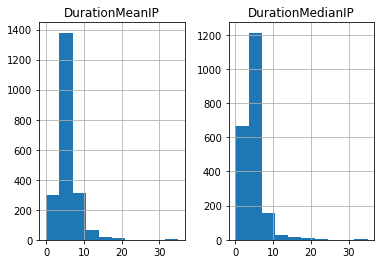

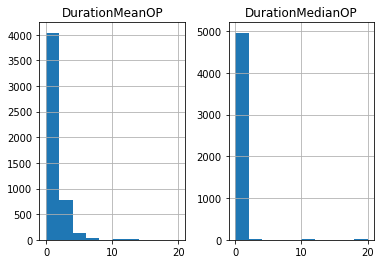

In [11]:
# Do we need an IP/OP split? Yes.

feat_duration_ip.hist()
plt.show()

feat_duration_op.hist()
plt.show()

In [12]:
# Making final feature

feat_duration_final = flags.merge(feat_duration_ip, how='left', on='Provider')
feat_duration_final = feat_duration_final.merge(feat_duration_op, how='left', on='Provider')

print(len(feat_duration_final))
feat_duration_final.head()

5410


,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP
0,PRV51001,No,4.0,5.000000,0.0,0.550000
1,PRV51003,Yes,4.0,5.161290,0.0,2.357143
2,PRV51004,No,NaN,NaN,0.0,1.429530
3,PRV51005,Yes,NaN,NaN,0.0,1.088412
4,PRV51007,No,5.0,5.333333,0.0,0.768116


## Hospitals that Serve Both IP and OP

In [13]:
# Make list of pros in ip and op separately

ip_pros = list(set(ip['Provider']))
op_pros = list(set(op['Provider']))

In [14]:
# Make df with IPs also in OP, and OPs also in IP, and then both!

ip_pros_df = pd.DataFrame(ip_pros, columns=['Provider'])
ip_pros_tf = ip_pros_df.isin(op_pros)
feat_both_ip = pd.concat([ip_pros_df, ip_pros_df.isin(op_pros).rename(columns={'Provider':'Serves'})], axis=1)
feat_both_ip['Serves'] = np.where(feat_both_ip['Serves']==0,'IP','Both')

op_pros_df = pd.DataFrame(op_pros, columns=['Provider'])
feat_both_op = pd.concat([op_pros_df, op_pros_df.isin(ip_pros).rename(columns={'Provider':'Serves'})], axis=1)
feat_both_op['Serves'] = np.where(feat_both_op['Serves']==0,'OP','Both')

feat_both_final = pd.concat([feat_both_ip, feat_both_op], axis=0, ignore_index=True).drop_duplicates()
feat_both_final = feat_both_final.merge(flags, on='Provider')

display(feat_both_ip.head())
display(feat_both_op.head())
feat_both_final.head()

,Provider,Serves
0,PRV57547,Both
1,PRV51062,Both
2,PRV57510,Both
3,PRV51831,IP
4,PRV52589,Both


,Provider,Serves
0,PRV53026,OP
1,PRV57510,Both
2,PRV56086,OP
3,PRV53957,OP
4,PRV55494,Both


,Provider,Serves,PotentialFraud
0,PRV57547,Both,Yes
1,PRV51062,Both,No
2,PRV57510,Both,No
3,PRV51831,IP,No
4,PRV52589,Both,Yes


In [15]:
print(len(feat_both_ip))
print(len(feat_both_op))
print(len(feat_both_final))

2092
5012
5410


## Number of Chronic Conditions per Pt

In [16]:
feat_conditions_ip = ip.groupby('Provider')['Diseases'].agg(['median','mean']).rename(columns={'median':'ChronCondsMedianIP', 'mean':'ChronCondsMeanIP'})
feat_conditions_ip['ChronConsModeIP'] = ip.groupby('Provider')['Diseases'].agg(pd.Series.mode)
feat_conditions_ip.reset_index(inplace=True)

feat_conditions_op = op.groupby('Provider')['Diseases'].agg(['median','mean']).rename(columns={'median':'ChronCondsMedianOP', 'mean':'ChronCondsMeanOP'})
feat_conditions_op['ChronConsModeOP'] = op.groupby('Provider')['Diseases'].agg(lambda x:x.value_counts().index[0])
feat_conditions_op.reset_index(inplace=True)

feat_conditions_ipop = ipop.groupby('Provider')['Diseases'].agg(['median','mean']).rename(columns={'median':'ChronCondsMedian', 'mean':'ChronCondsMean'})
feat_conditions_ipop['ChronConsMode'] = ipop.groupby('Provider')['Diseases'].agg(pd.Series.mode)
feat_conditions_ipop.reset_index(inplace=True)

feat_conditions_ip.head()

,Provider,ChronCondsMedianIP,ChronCondsMeanIP,ChronConsModeIP
0,PRV51001,5.0,5.400000,5
1,PRV51003,6.5,6.354839,7
2,PRV51007,6.0,5.666667,6
3,PRV51008,7.5,7.500000,"[7, 8]"
4,PRV51011,5.0,5.000000,5


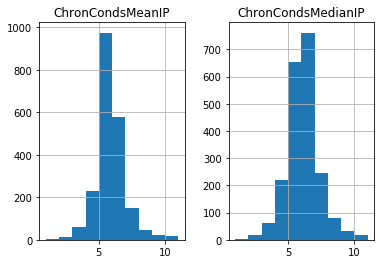

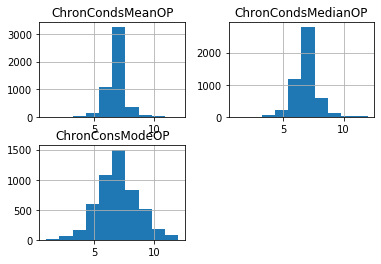

In [17]:
# Do we need an IP/OP split? No.

feat_conditions_ip.hist()
plt.show()

feat_conditions_op.hist()
plt.show()

In [18]:
# Making final feature

feat_conditions_final = flags.merge(feat_conditions_ipop, how='left', on='Provider')
feat_conditions_final['ChronConsMode'] = feat_conditions_final['ChronConsMode']\
    .apply(lambda x: x.mean() if type(x) != np.int64 else x)

print(len(feat_conditions_final))
feat_conditions_final.head(10)

5410


,Provider,PotentialFraud,ChronCondsMedian,ChronCondsMean,ChronConsMode
0,PRV51001,No,6.0,5.760000,5.000000
1,PRV51003,Yes,7.0,6.674242,6.000000
2,PRV51004,No,7.0,6.812081,8.000000
3,PRV51005,Yes,7.0,6.886695,5.000000
4,PRV51007,No,7.0,6.986111,6.000000
5,PRV51008,No,7.0,7.325581,7.000000
6,PRV51011,No,7.0,6.620690,5.500000
7,PRV51012,No,6.5,6.520833,4.000000
8,PRV51013,No,7.0,6.826087,8.000000
9,PRV51014,No,7.0,6.933333,6.333333


## Average Age of Pt

In [19]:
feat_age_ip = ip.groupby('Provider')['Age'].agg(['median','mean']).rename(columns={'median':'PtAgeMedianIP', 'mean':'PtAgeMeanIP'}).reset_index()
feat_age_op = op.groupby('Provider')['Age'].agg(['median','mean']).rename(columns={'median':'PtAgeMedianOP', 'mean':'PtAgeMeanOP'}).reset_index()
feat_age_ipop = ipop.groupby('Provider')['Age'].agg(['median','mean']).rename(columns={'median':'PtAgeMedian', 'mean':'PtAgeMean'}).reset_index()
feat_age_ip.head()


,Provider,PtAgeMedianIP,PtAgeMeanIP
0,PRV51001,74.0,77.600000
1,PRV51003,74.0,69.903226
2,PRV51007,78.0,77.666667
3,PRV51008,50.5,50.500000
4,PRV51011,97.0,97.000000


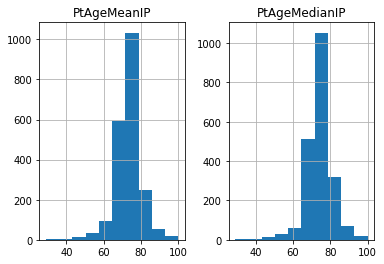

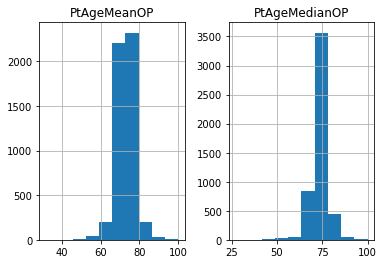

In [20]:
# Do we need an IP/OP split? No.

feat_age_ip.hist()
plt.show()

feat_age_op.hist()
plt.show()

In [21]:
# Making final feature

feat_age_final = flags.merge(feat_age_ipop, how='left', on='Provider')
print(len(feat_age_final))
feat_age_final.head()

5410


,Provider,PotentialFraud,PtAgeMedian,PtAgeMean
0,PRV51001,No,79.0,77.880000
1,PRV51003,Yes,71.0,69.083333
2,PRV51004,No,72.0,71.261745
3,PRV51005,Yes,70.0,69.526180
4,PRV51007,No,69.5,68.305556


## Number of Pts

In [22]:
feat_patients_ip = pd.DataFrame(ip.groupby('Provider')['BeneID'].nunique()).rename(columns={'BeneID':'NumPtsIP'}).reset_index()
feat_patients_op = pd.DataFrame(op.groupby('Provider')['BeneID'].nunique()).rename(columns={'BeneID':'NumPtsOP'}).reset_index()
feat_patients_ipop = pd.DataFrame(op.groupby('Provider')['BeneID'].nunique()).rename(columns={'BeneID':'NumPts'}).reset_index()
feat_patients_ip.head()

,Provider,NumPtsIP
0,PRV51001,5
1,PRV51003,53
2,PRV51007,3
3,PRV51008,2
4,PRV51011,1


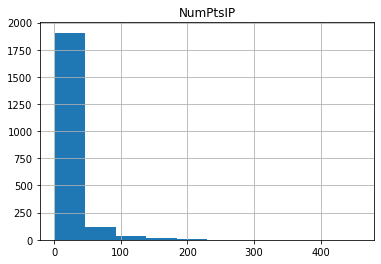

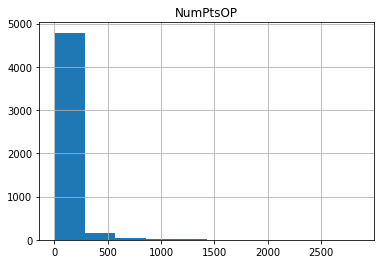

In [23]:
# Do we need an IP/OP split? Yes.

feat_patients_ip.hist()
plt.show()

feat_patients_op.hist()
plt.show()

In [24]:
# Making final feature

feat_patients_final = flags.merge(feat_patients_ip, how='left', on='Provider')
feat_patients_final = feat_patients_final.merge(feat_patients_op, how='left', on='Provider')
# feat_patients_final = feat_patients_final.merge(feat_patients_ipop, how='left', on='Provider')

print(len(feat_patients_final))
feat_patients_final.head()

5410


,Provider,PotentialFraud,NumPtsIP,NumPtsOP
0,PRV51001,No,5.0,19.0
1,PRV51003,Yes,53.0,66.0
2,PRV51004,No,NaN,138.0
3,PRV51005,Yes,NaN,495.0
4,PRV51007,No,3.0,56.0


## States Served

In [25]:
feat_states_ip = pd.DataFrame(ip.groupby('Provider')['State'].nunique()).rename(columns={'State':'NumStatesIP'}).reset_index()
feat_states_op = pd.DataFrame(op.groupby('Provider')['State'].nunique()).rename(columns={'State':'NumStatesOP'}).reset_index()
feat_states_ipop = pd.DataFrame(op.groupby('Provider')['State'].nunique()).rename(columns={'State':'NumStates'}).reset_index()
feat_states_ip.head()


,Provider,NumStatesIP
0,PRV51001,1
1,PRV51003,3
2,PRV51007,1
3,PRV51008,1
4,PRV51011,1


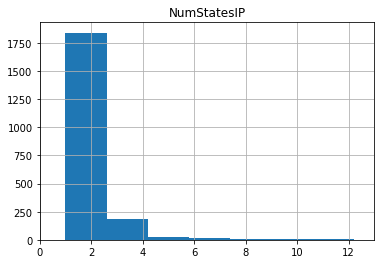

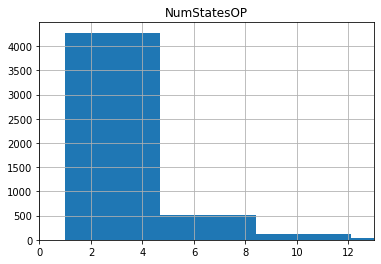

Ttest_indResult(statistic=-15.371409811239857, pvalue=1.7697718514496237e-52)

In [26]:
# Do we need an IP/OP split? Yes.

feat_states_ip.hist()
plt.xlim(0,13)
plt.show()

feat_states_op.hist()
plt.xlim(0,13)
plt.show()

from scipy import stats

stats.ttest_ind(feat_states_ip['NumStatesIP'], feat_states_op['NumStatesOP'])

In [27]:
# Making final feature

feat_states_final = flags.merge(feat_states_ip, how='left', on='Provider')
feat_states_final = feat_states_final.merge(feat_states_op, how='left', on='Provider')

print(len(feat_states_final))
feat_states_final.head()

5410


,Provider,PotentialFraud,NumStatesIP,NumStatesOP
0,PRV51001,No,1.0,1.0
1,PRV51003,Yes,3.0,3.0
2,PRV51004,No,NaN,9.0
3,PRV51005,Yes,NaN,4.0
4,PRV51007,No,1.0,2.0


## Merge All Zack Features

In [28]:
from functools import reduce

# full_ip = reduce(lambda x,y: pd.merge(x,y, on='Provider', how='outer'), [feat_duration_ip, feat_both_ip, feat_conditions_ip,feat_age_ip,feat_patients_ip,feat_states_ip])
# full_op = reduce(lambda x,y: pd.merge(x,y, on='Provider', how='outer'), [feat_duration_op, feat_both_op, feat_conditions_op,feat_age_op,feat_patients_op,feat_states_op])
# full_ipop = reduce(lambda x,y: pd.merge(x,y, on='Provider', how='outer'), [feat_duration_ipop, feat_both_ipop, feat_conditions_ipop,feat_age_ipop,feat_patients_ipop,feat_states_ipop])

full_final = reduce(lambda x,y: pd.merge(x,y, on=['Provider','PotentialFraud'], how='outer'), [feat_duration_final, feat_both_final, feat_conditions_final,feat_age_final,feat_patients_final,feat_states_final])


In [29]:
print(len(full_final))
full_final.head()

5410


,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP
0,PRV51001,No,4.0,5.000000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0
1,PRV51003,Yes,4.0,5.161290,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0
2,PRV51004,No,NaN,NaN,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,NaN,138.0,NaN,9.0
3,PRV51005,Yes,NaN,NaN,0.0,1.088412,OP,7.0,6.886695,5.0,70.0,69.526180,NaN,495.0,NaN,4.0
4,PRV51007,No,5.0,5.333333,0.0,0.768116,Both,7.0,6.986111,6.0,69.5,68.305556,3.0,56.0,1.0,2.0


## Analysis of Zack's Full Final Table

In [30]:
full_final.isna().sum()

Provider               0
PotentialFraud         0
DurationMedianIP    3318
DurationMeanIP      3318
DurationMedianOP     398
DurationMeanOP       398
Serves                 0
ChronCondsMedian       0
ChronCondsMean         0
ChronConsMode          0
PtAgeMedian            0
PtAgeMean              0
NumPtsIP            3318
NumPtsOP             398
NumStatesIP         3318
NumStatesOP          398
dtype: int64

In [31]:
full_final.Serves.value_counts()

OP      3318
Both    1694
IP       398
Name: Serves, dtype: int64

In [32]:
# Make fraud/no_fraud tables

no_fraud = full_final.loc[full_final['PotentialFraud'] == 'No']
fraud = full_final.loc[full_final['PotentialFraud'] == 'Yes']

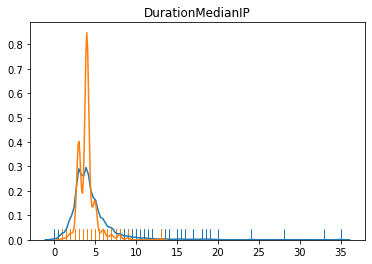

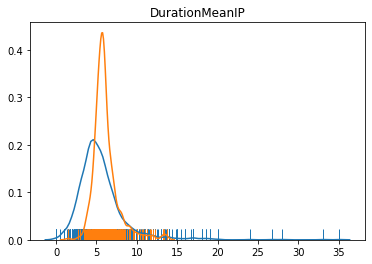

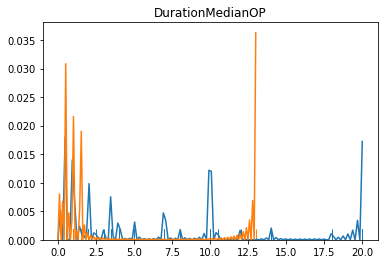

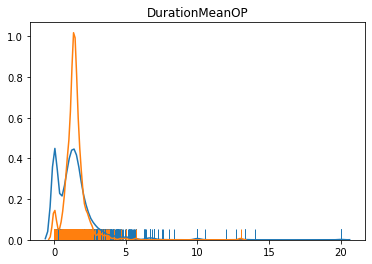

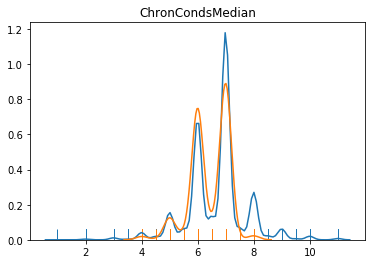

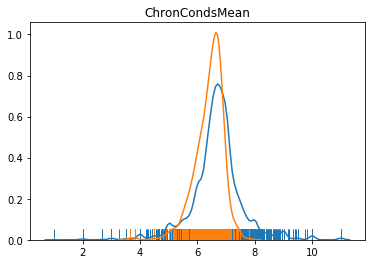

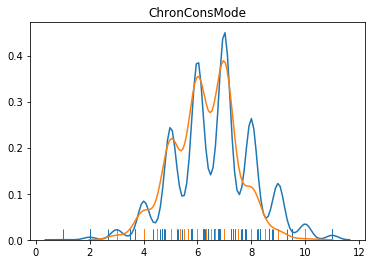

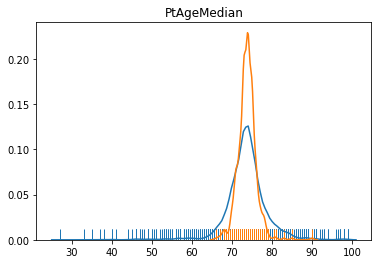

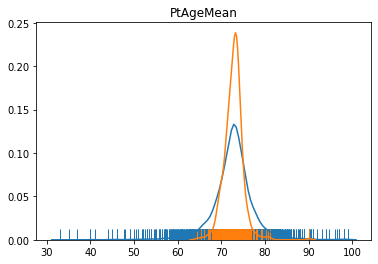

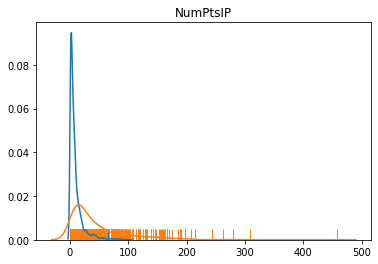

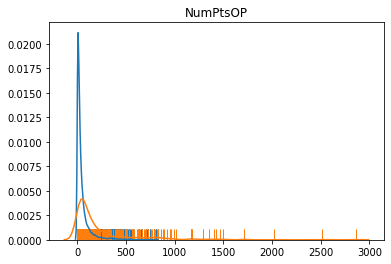

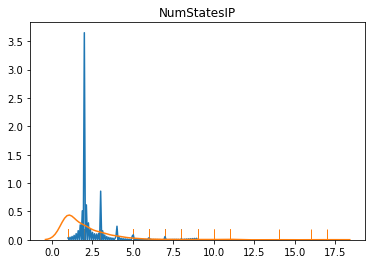

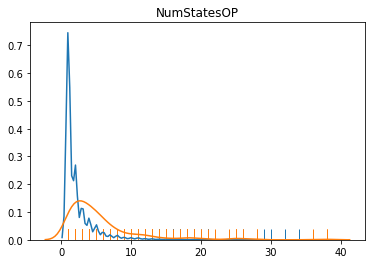

In [34]:
# Plot all features, separating fraud and no_fraud

col_list = list(full_final.columns)[2:]
col_list.remove('Serves')
col_list

for x in col_list:
    sns.distplot(no_fraud[[x]], hist=False, rug=True)
    sns.distplot(fraud[[x]], hist=False, rug=True)
    plt.title(x)
    plt.show()

## Final Provider Table

In [57]:
# Read in collaborator tables

pat = pd.read_csv('../../../processed_data/Merge_final.csv')
# lu = pd.read_csv('../processed_data/provider_dup_short.csv')
lu = pd.read_csv('../processed_data/lu3.csv')
el = pd.read_csv('../processed_data/el1.csv')
# el2 = pd.read_csv('../processed_data/el2.csv')

print('Pat ', len(pat))
display(pat.head())
print('Lu ', len(lu))
display(lu.head())
print('Elina 1', len(el))
display(el.head())
# print('Elina 2', len(el))
# el2.head()

Pat  5410


,Provider,SharePhysician,MergeTotalClaim,MergeTotalPatient,MergeAvgClaimReimbursed,PotentialFraud,NumTopCodeClaim
0,PRV51001,1.0,25,24,4185.600000,No,5.0
1,PRV51003,1.0,132,117,4588.409091,Yes,25.0
2,PRV51004,1.0,149,138,350.134228,No,5.0
3,PRV51005,1.0,1165,495,241.124464,Yes,25.0
4,PRV51007,1.0,72,58,468.194444,No,3.0


Lu  5410


,Provider,PotentialFraud,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP
0,PRV51001,No,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes
1,PRV51003,Yes,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes
2,PRV51004,No,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,72.0,0.483221,yes,52.0,yes,3006.0,yes,375.0,yes
3,PRV51005,Yes,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,530.0,0.454936,yes,52.0,yes,3920.0,yes,382.0,yes
4,PRV51007,No,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,29.0,0.420290,yes,52.0,yes,1816.0,yes,371.0,yes


Elina 1 5410


,Unnamed: 0,Provider,PotentialFraud,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
0,0,PRV51003,Yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
1,1,PRV51005,Yes,1.09,495,1165,2.35,284610,574.97,2,98,1165,3.27
2,2,PRV51021,Yes,2.00,208,257,1.24,380322,1828.47,1,17,240,1.46
3,3,PRV51037,Yes,1.53,206,454,2.20,367754,1785.21,3,37,445,1.66
4,4,PRV51052,Yes,2.28,37,46,1.24,33146,895.84,0,3,45,1.10


In [58]:
# Drop old index on el table, duplicate features on pat

el.drop(['Unnamed: 0'], axis=1, inplace=True)
pat.drop(['MergeTotalClaim','MergeTotalPatient'], axis=1, inplace=True)

display(el.head())
display(pat.head())

,Provider,PotentialFraud,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
0,PRV51003,Yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
1,PRV51005,Yes,1.09,495,1165,2.35,284610,574.97,2,98,1165,3.27
2,PRV51021,Yes,2.00,208,257,1.24,380322,1828.47,1,17,240,1.46
3,PRV51037,Yes,1.53,206,454,2.20,367754,1785.21,3,37,445,1.66
4,PRV51052,Yes,2.28,37,46,1.24,33146,895.84,0,3,45,1.10


,Provider,SharePhysician,MergeAvgClaimReimbursed,PotentialFraud,NumTopCodeClaim
0,PRV51001,1.0,4185.600000,No,5.0
1,PRV51003,1.0,4588.409091,Yes,25.0
2,PRV51004,1.0,350.134228,No,5.0
3,PRV51005,1.0,241.124464,Yes,25.0
4,PRV51007,1.0,468.194444,No,3.0


In [59]:
# Merge all

final = reduce(lambda x,y: pd.merge(x,y, on=['Provider','PotentialFraud'], how='outer'), [full_final, pat, lu, el])

print(final.shape)
final.sample(7)

(5410, 47)


,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
3876,PRV55850,No,3.0,4.277778,0.0,1.307339,Both,7.0,7.055085,8.00,72.0,70.864407,18.0,136.0,2.0,4.0,1.0,1762.881356,11.0,1.0,0.055556,yes,2.0,yes,2.0,yes,2.0,yes,101.0,0.463303,yes,52.0,yes,3231.0,yes,377.0,yes,1.53,153,236,1.54,418596,2735.92,0,21,224,1.31
3617,PRV55536,No,4.0,5.454545,0.0,1.004739,Both,7.0,6.639640,7.00,74.0,74.369369,7.0,105.0,1.0,2.0,1.0,668.243243,10.0,1.0,0.090909,yes,2.0,yes,2.0,yes,2.0,yes,91.0,0.431280,yes,52.0,yes,2826.0,yes,373.0,yes,1.23,106,222,2.09,160778,1516.77,0,22,216,1.36
2008,PRV53504,No,NaN,NaN,0.0,0.250000,OP,7.0,7.000000,7.00,72.5,75.250000,NaN,4.0,NaN,1.0,1.0,182.500000,0.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,3.0,0.750000,yes,51.0,yes,701.0,yes,353.0,yes,0.25,4,4,1.00,730,182.50,0,0,4,1.00
5229,PRV57545,No,4.0,4.000000,0.0,0.816667,Both,6.0,6.639344,5.00,74.0,71.770492,1.0,53.0,1.0,2.0,1.0,662.786885,0.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,22.0,0.366667,yes,52.0,yes,1324.0,yes,367.0,yes,0.87,54,61,1.13,41598,770.33,0,6,60,1.03
704,PRV51877,No,NaN,NaN,0.0,0.000000,OP,6.5,7.250000,7.25,71.5,74.250000,NaN,4.0,NaN,1.0,1.0,72.500000,1.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,3.0,0.750000,yes,40.0,yes,127.0,yes,108.0,yes,0.00,4,4,1.00,290,72.50,0,0,4,1.00
3930,PRV55914,Yes,3.0,6.000000,0.0,1.428571,Both,7.0,6.682540,7.00,77.0,75.619048,21.0,41.0,4.0,5.0,1.0,2708.888889,9.0,3.0,0.142857,yes,6.0,yes,4.0,yes,6.0,yes,19.0,0.452381,yes,52.0,yes,2667.0,yes,371.0,yes,2.95,62,63,1.02,193178,3115.77,0,7,54,1.09
3315,PRV55157,No,7.0,5.333333,NaN,NaN,IP,6.0,5.333333,6.00,79.0,78.000000,3.0,NaN,1.0,NaN,1.0,5333.333333,1.0,1.0,0.333333,yes,2.0,yes,2.0,yes,2.0,yes,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,5.33,3,3,1.00,19204,6401.33,0,0,1,1.00


In [60]:
# Check to make sure things merged in line!

display(full_final[full_final['Provider']=='PRV55157'])
display(pat[pat['Provider']=='PRV55157'])
display(lu[lu['Provider']=='PRV55157'])
display(el[el['Provider']=='PRV55157'])

,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP
3315,PRV55157,No,7.0,5.333333,NaN,NaN,IP,6.0,5.333333,6.0,79.0,78.0,3.0,NaN,1.0,NaN


,Provider,SharePhysician,MergeAvgClaimReimbursed,PotentialFraud,NumTopCodeClaim
3139,PRV55157,1.0,5333.333333,No,1.0


,Provider,PotentialFraud,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP
3315,PRV55157,No,1.0,0.333333,yes,2.0,yes,2.0,yes,2.0,yes,0.0,0.0,no,0.0,no,0.0,no,0.0,no


,Provider,PotentialFraud,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
3502,PRV55157,No,5.33,3,3,1.0,19204,6401.33,0,0,1,1.0


In [61]:
# Check null values

final.isna().sum()

Provider                       0
PotentialFraud                 0
DurationMedianIP            3318
DurationMeanIP              3318
DurationMedianOP             398
DurationMeanOP               398
Serves                         0
ChronCondsMedian               0
ChronCondsMean                 0
ChronConsMode                  0
PtAgeMedian                    0
PtAgeMean                      0
NumPtsIP                    3318
NumPtsOP                     398
NumStatesIP                 3318
NumStatesOP                  398
SharePhysician                 0
MergeAvgClaimReimbursed        0
NumTopCodeClaim                0
DupClaimNum_IP                 0
DupClaimRatio_IP               0
DupClaim_IP                    0
DupClaimStatesNum_IP           0
DupClaimMultiState_IP          0
DupClaimProviderNum_IP         0
DupClaimMultiProvider_IP       0
DupClaimStartDtNum_IP          0
DupClaimMultiStartDt_IP        0
DupClaimNum_OP                 0
DupClaimRatio_OP               0
DupClaim_O

In [62]:
final.fillna(0, inplace=True)
final.isnull().sum()

Provider                    0
PotentialFraud              0
DurationMedianIP            0
DurationMeanIP              0
DurationMedianOP            0
DurationMeanOP              0
Serves                      0
ChronCondsMedian            0
ChronCondsMean              0
ChronConsMode               0
PtAgeMedian                 0
PtAgeMean                   0
NumPtsIP                    0
NumPtsOP                    0
NumStatesIP                 0
NumStatesOP                 0
SharePhysician              0
MergeAvgClaimReimbursed     0
NumTopCodeClaim             0
DupClaimNum_IP              0
DupClaimRatio_IP            0
DupClaim_IP                 0
DupClaimStatesNum_IP        0
DupClaimMultiState_IP       0
DupClaimProviderNum_IP      0
DupClaimMultiProvider_IP    0
DupClaimStartDtNum_IP       0
DupClaimMultiStartDt_IP     0
DupClaimNum_OP              0
DupClaimRatio_OP            0
DupClaim_OP                 0
DupClaimStatesNum_OP        0
DupClaimMultiState_OP       0
DupClaimPr

In [63]:
# Send it!

final.to_csv('../../../processed_data/provider_final.csv')

In [64]:
# Check

check = pd.read_csv('../../../processed_data/provider_final.csv')
print(check.shape)
display(check.head())
check.isna().sum()

(5410, 48)


,Unnamed: 0,Provider,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
0,0,PRV51001,No,4.0,5.000000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0,1.0,4185.600000,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes,1.44,24,25,1.04,109980,4582.50,0,2,23,1.09
1,1,PRV51003,Yes,4.0,5.161290,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0,1.0,4588.409091,25.0,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
2,2,PRV51004,No,0.0,0.000000,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,0.0,138.0,0.0,9.0,1.0,350.134228,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,72.0,0.483221,yes,52.0,yes,3006.0,yes,375.0,yes,1.43,138,149,1.08,52480,380.29,0,12,149,1.27
3,3,PRV51005,Yes,0.0,0.000000,0.0,1.088412,OP,7.0,6.886695,5.0,70.0,69.526180,0.0,495.0,0.0,4.0,1.0,241.124464,25.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,530.0,0.454936,yes,52.0,yes,3920.0,yes,382.0,yes,1.09,495,1165,2.35,284610,574.97,2,98,1165,3.27
4,4,PRV51007,No,5.0,5.333333,0.0,0.768116,Both,7.0,6.986111,6.0,69.5,68.305556,3.0,56.0,1.0,2.0,1.0,468.194444,3.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,29.0,0.420290,yes,52.0,yes,1816.0,yes,371.0,yes,0.96,58,72,1.24,36974,637.48,0,8,71,1.06


Unnamed: 0                  0
Provider                    0
PotentialFraud              0
DurationMedianIP            0
DurationMeanIP              0
DurationMedianOP            0
DurationMeanOP              0
Serves                      0
ChronCondsMedian            0
ChronCondsMean              0
ChronConsMode               0
PtAgeMedian                 0
PtAgeMean                   0
NumPtsIP                    0
NumPtsOP                    0
NumStatesIP                 0
NumStatesOP                 0
SharePhysician              0
MergeAvgClaimReimbursed     0
NumTopCodeClaim             0
DupClaimNum_IP              0
DupClaimRatio_IP            0
DupClaim_IP                 0
DupClaimStatesNum_IP        0
DupClaimMultiState_IP       0
DupClaimProviderNum_IP      0
DupClaimMultiProvider_IP    0
DupClaimStartDtNum_IP       0
DupClaimMultiStartDt_IP     0
DupClaimNum_OP              0
DupClaimRatio_OP            0
DupClaim_OP                 0
DupClaimStatesNum_OP        0
DupClaimMu

In [70]:
final.DupClaimNum_OP.unique()

array([1.100e+01, 2.500e+01, 7.200e+01, 5.300e+02, 2.900e+01, 1.500e+01,
       2.700e+01, 2.000e+01, 1.800e+01, 8.000e+00, 3.000e+00, 2.000e+00,
       2.030e+02, 1.020e+02, 1.400e+01, 3.100e+01, 4.400e+01, 3.000e+01,
       3.200e+01, 4.200e+01, 1.200e+01, 1.700e+01, 1.160e+02, 1.870e+02,
       5.600e+01, 3.300e+01, 6.700e+01, 1.300e+01, 2.300e+01, 1.600e+01,
       5.000e+00, 0.000e+00, 7.000e+00, 1.000e+00, 2.600e+01, 3.500e+01,
       6.900e+01, 1.600e+02, 1.050e+02, 6.000e+00, 9.000e+00, 1.070e+02,
       8.000e+01, 4.000e+00, 8.400e+01, 3.600e+01, 4.800e+01, 9.600e+01,
       5.100e+01, 5.000e+01, 1.240e+02, 5.900e+01, 1.210e+02, 4.300e+01,
       1.000e+01, 1.900e+01, 1.840e+02, 2.100e+01, 9.700e+01, 1.170e+02,
       1.060e+02, 3.700e+01, 7.900e+01, 2.410e+02, 2.450e+02, 1.650e+02,
       7.800e+01, 2.080e+02, 4.900e+01, 2.400e+01, 2.800e+01, 3.090e+02,
       2.400e+02, 2.200e+01, 5.510e+02, 4.500e+01, 6.200e+01, 2.710e+02,
       1.080e+02, 1.630e+02, 3.400e+01, 3.800e+01, 

In [56]:
final[['MergeTotalPatient','NumOfPt']]

,MergeTotalPatient,NumOfPt
0,24,24
1,117,117
2,138,138
3,495,495
4,58,58
5,36,36
6,53,53
7,31,31
8,44,44
9,25,25
